# 手寫阿拉伯數字辨識 with CNN

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
# 設定參數
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1000  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：資料清理，此步驟無需進行

## 步驟3：特徵工程，此步驟無需進行

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [4]:
# 卷積/池化層公式計算
import math

# W, F, P, S：image Width, Filter width, Padding, Stride 
def Conv_Width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def Conv_Output_Volume(W, F, P, S, out):
    return Conv_Width(W, F, P, S) ** 2 * out

# C: no of channels
def Conv_Parameter_Count(F, C, out):
    return F ** 2 * C * out

def Pool_Width(W, F, P, S):
    return Conv_Width(W, F, P, S)

# filter_count: no of filter in last conv 
# stride count default value = Filter width
def Pool_Output_Volume(W, F, P, S, filter_count):
    return Conv_Output_Volume(W, F, P, S, filter_count)

def Pool_Parameter_Count(W, F, S):
    return 0

In [5]:
# test
print(Pool_Width(Conv_Width(32, 3, 1, 1), 2, 0, 2))
print(Pool_Width(Conv_Width(16, 3, 1, 1), 2, 0, 2))
print(Pool_Width(Conv_Width(8, 3, 1, 1), 2, 0, 2))

def Conv_Pool_Width(W, F, P, S, F2, P2, S2, n):
    for i in range(n):
        W = Pool_Width(Conv_Width(W, F, P, S), F2, P2, S2)
    return W

Conv_Pool_Width(32, 3, 1, 1, 2, 0, 2, 3)

16
8
4


4

In [6]:
Conv_Width(28, 3, 0, 1)

26

In [7]:
# Input: 227x227x3 images, CONV1: 96 11x11 filters applied at stride 4
print(Conv_Width(227, 11, 0, 4), Conv_Output_Volume(227, 11, 0, 4, 96), Conv_Parameter_Count(11, 3, 96))
print(math.floor((227-11)/4)+1, 55*55*96, (11*11*3)*96)

55 290400 34848
55 290400 34848


In [8]:
# Conv2d/MaxPool2d/Conv2d/MaxPool2d
c1_Width = Conv_Width(28, 5, 2, 1)
p1_Width = Pool_Width(c1_Width, 2, 0, 2)
c2_Width = Conv_Width(p1_Width, 5, 2, 1)
p2_out = Pool_Output_Volume(c2_Width, 2, 0, 2, 32)
p2_out, 7*7*32

(1568, 1568)

In [9]:
# 建立模型
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # Conv2d 參數： in-channel, out-channel, kernel size, Stride, Padding
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

model = ConvNet().to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [10]:
epochs = 10
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

# 設定優化器(optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [10000 / 60000] (17 %)  Loss: 2.879874
Epoch 1: [20000 / 60000] (33 %)  Loss: 2.337525
Epoch 1: [30000 / 60000] (50 %)  Loss: 2.393248
Epoch 1: [40000 / 60000] (67 %)  Loss: 2.262269
Epoch 1: [50000 / 60000] (83 %)  Loss: 2.084842
Epoch 1: [60000 / 60000] (100 %)  Loss: 1.739147
Epoch 2: [10000 / 60000] (17 %)  Loss: 1.068708
Epoch 2: [20000 / 60000] (33 %)  Loss: 0.731779
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.688745
Epoch 2: [40000 / 60000] (67 %)  Loss: 0.643861
Epoch 2: [50000 / 60000] (83 %)  Loss: 0.608218
Epoch 2: [60000 / 60000] (100 %)  Loss: 0.355083
Epoch 3: [10000 / 60000] (17 %)  Loss: 0.414634
Epoch 3: [20000 / 60000] (33 %)  Loss: 0.337860
Epoch 3: [30000 / 60000] (50 %)  Loss: 0.393468
Epoch 3: [40000 / 60000] (67 %)  Loss: 0.407774
Epoch 3: [50000 / 60000] (83 %)  Loss: 0.438660
Epoch 3: [60000 / 60000] (100 %)  Loss: 0.267671
Epoch 4: [10000 / 60000] (17 %)  Loss: 0.339682
Epoch 4: [20000 / 60000] (33 %)  Loss: 0.271168
Epoch 4: [30000 / 60000] (50 %)  Loss

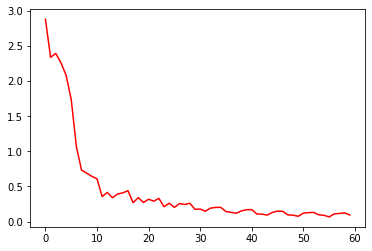

In [11]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [12]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target).item()
        
        # 預測
        output = model(data)
        
        # 計算正確數
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

# 平均損失
test_loss /= len(test_loader.dataset) 
# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count 
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.2f}%)\n')

平均損失: 0.0001, 準確率: 9711/10000 (97.11%)



In [13]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


In [14]:
# 顯示第 9 筆的機率
import numpy as np

i=18
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

torch.Size([1, 1, 28, 28])
0~9預測機率: [[0.   0.   0.   0.7  0.   0.19 0.   0.   0.11 0.  ]]
0~9預測機率: [3]


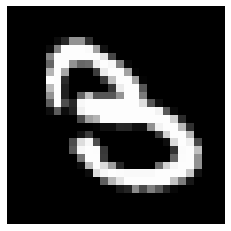

In [15]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0] 
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

In [16]:
test_ds[i][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [17]:
# 模型存檔
torch.save(model, 'cnn_model.pth')

# 模型載入
model = torch.load('cnn_model.pth')

## 步驟10：新資料預測

In [18]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize

no=9
uploaded_file = f'./myDigits/{no}.png'
image1 = io.imread(uploaded_file, as_gray=True)

# 縮為 (28, 28) 大小的影像
data_shape = data.shape
image_resized = resize(image1, data_shape[2:], anti_aliasing=True)    
X1 = image_resized.reshape(*data_shape) #/ 255.0
#print(X1[0])
# 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
X1 = 1.0-X1

for i in range(X1[0][0].shape[0]):
    for j in range(X1[0][0].shape[1]):
        print(f'{X1[0][0][i][j]:.4f}', end=' ')
    print()

0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0009 0.0034 0.0039 0.0039 0.0023 0.0002 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0004 0.0095 0.0545 0.1573 0.3003 0.3288 0.3262 0.2312 0.0661 0.0030 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0015 0.0639 0.3497 0.6573 0.8451 0.8961 0.9010 0.9000 0.8651 0.6149 0.0771 0.0003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0

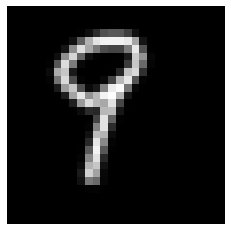

In [19]:
# 顯示第10張圖片圖像
import matplotlib.pyplot as plt

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X1.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

In [20]:
# 將非0的數字轉為1，顯示第1張圖片
X2 = X1[0][0].copy()
X2[X2>0.1]=1
print(type(X2), X2[0].shape)
# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(X2.shape[0]):
    text_image.append(''.join(X2[i].astype(int).astype(str)))
text_image

<class 'numpy.ndarray'> (28,)


['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000011111000000000000',
 '0000000001111111100000000000',
 '0000000011111111110000000000',
 '0000000111000001110000000000',
 '0000001110000001110000000000',
 '0000001100000011110000000000',
 '0000001110000111100000000000',
 '0000000111001111000000000000',
 '0000000111111110000000000000',
 '0000000011111110000000000000',
 '0000000000111100000000000000',
 '0000000000011100000000000000',
 '0000000000011100000000000000',
 '0000000000011000000000000000',
 '0000000000111000000000000000',
 '0000000000111000000000000000',
 '0000000000111000000000000000',
 '0000000000110000000000000000',
 '0000000001110000000000000000',
 '0000000000110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [21]:
data_shape = X1.shape
data_shape

(1, 1, 28, 28)

In [22]:
X1 = torch.FloatTensor(X1).to(device)

# 預測
predictions = model(X1)
# print(np.around(predictions.cpu().detach().numpy(), 2))
print(f'actual/prediction: {no} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 9 7


In [23]:
model(X1)

tensor([[-7.3714, -4.0189, -2.9344, -4.2950, -9.5384, -3.7033, -9.8322, -0.8409,
         -0.9202, -2.8120]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [24]:
# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, tuple(data_shape)[2:], anti_aliasing=True)    
    X1 = image_resized.reshape(*data_shape) 
    
    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-X1
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 7
actual/prediction: 8 8
actual/prediction: 9 7


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [25]:
# 顯示模型的彙總資訊
for name, module in model.named_children():
    print(f'{name}: {module}')

layer1: Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
layer2: Sequential(
  (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
fc: Linear(in_features=1568, out_features=10, bias=True)
